In [1]:
'''
使用CNN做车辆颜色分析
'''
# 导入包
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 设置参数
num_classes = 8
LR = 0.001
num_epochs = 100

print(device)

cuda


#### 加载数据集

In [3]:
# 数据预处理
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Prepare the dataset and dataloader
dataset = ImageFolder('./ColorData', transform=transform)
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### 定义网络结构

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)  # 输入图片64x64
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))   # 64x64 → 32x32
        x = self.pool(torch.relu(self.conv2(x)))   # 32x32 → 16x16
        x = x.view(x.size(0), -1)                  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


#### 训练模型

In [5]:
import os
import torch
import torch.nn as nn

def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=50, save_path='./models/best_model.pth'):
    model = model.to(device)

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    best_acc = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        # ---------- 验证 ----------
        model.eval()
        test_loss = 0
        test_correct = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = test_correct / len(test_loader.dataset)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}")

        # ---------- 保存最优模型 ----------
        if test_acc > best_acc:
            best_acc = test_acc
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(model.state_dict(), save_path)

    return train_loss_list, train_acc_list, test_loss_list, test_acc_list, best_acc


In [6]:
model = CNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [7]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list, best_acc= train_and_evaluate_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    save_path='./models/CNN_best_model.pth'
)


Epoch [1/100]
Train Loss: 1.7894, Train Acc: 0.3510, Test  Loss: 1.3527, Test  Acc: 0.6040
Epoch [2/100]
Train Loss: 1.0506, Train Acc: 0.6556, Test  Loss: 0.8439, Test  Acc: 0.6832
Epoch [3/100]
Train Loss: 0.6347, Train Acc: 0.7450, Test  Loss: 0.6210, Test  Acc: 0.8020
Epoch [4/100]
Train Loss: 0.4946, Train Acc: 0.8046, Test  Loss: 0.7489, Test  Acc: 0.7921
Epoch [5/100]
Train Loss: 0.3571, Train Acc: 0.8907, Test  Loss: 0.7538, Test  Acc: 0.7723
Epoch [6/100]
Train Loss: 0.3333, Train Acc: 0.8808, Test  Loss: 0.5230, Test  Acc: 0.8911
Epoch [7/100]
Train Loss: 0.2450, Train Acc: 0.9106, Test  Loss: 0.5412, Test  Acc: 0.8713
Epoch [8/100]
Train Loss: 0.1930, Train Acc: 0.9371, Test  Loss: 0.4748, Test  Acc: 0.9208
Epoch [9/100]
Train Loss: 0.1871, Train Acc: 0.9371, Test  Loss: 0.5515, Test  Acc: 0.9208
Epoch [10/100]
Train Loss: 0.1485, Train Acc: 0.9503, Test  Loss: 0.5307, Test  Acc: 0.9208
Epoch [11/100]
Train Loss: 0.1190, Train Acc: 0.9536, Test  Loss: 0.4971, Test  Acc: 0.93

#### 绘制loss和accuracy的变化曲线

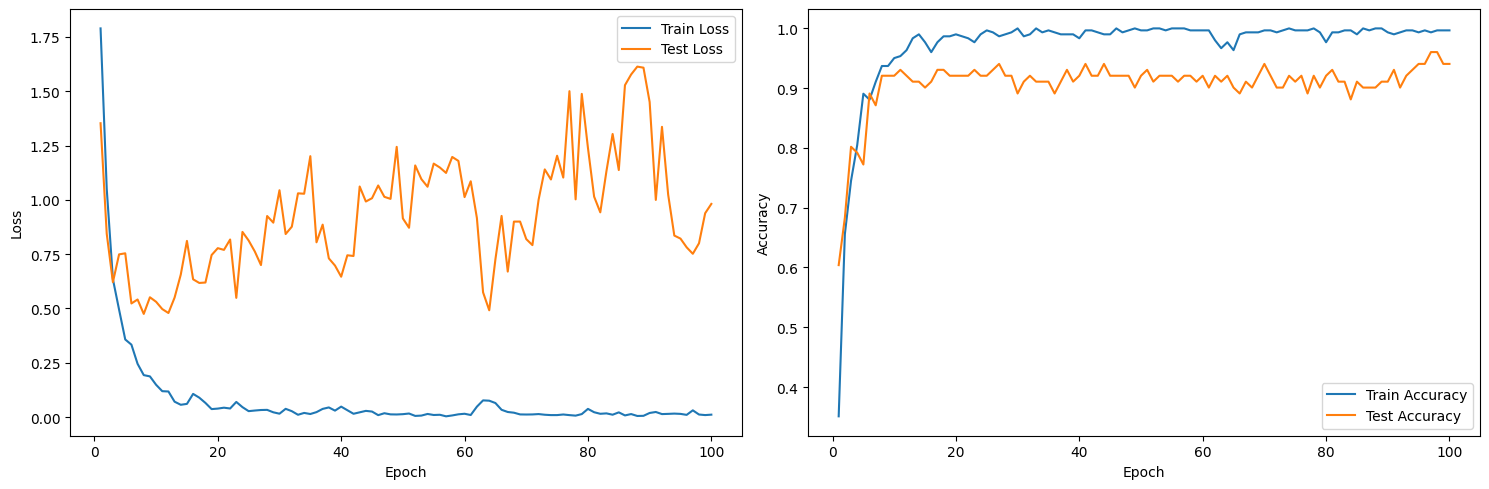

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      1.00      1.00        13
           2       1.00      0.88      0.93        16
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00        13
           5       0.95      0.95      0.95        22
           6       0.93      0.93      0.93        15
           7       1.00      1.00      1.00         7

    accuracy                           0.96       101
   macro avg       0.96      0.97      0.96       101
weighted avg       0.96      0.96      0.96       101



In [8]:
import matplotlib.pyplot as plt
# 绘制loss和accuracy的变化曲线
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


from sklearn.metrics import classification_report
# 加载最佳模型
model.load_state_dict(torch.load("./models/CNN_best_model.pth"))

# 模型评估
model.eval()
predictions = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

print(classification_report(labels_list, predictions))
